In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go

In [2]:
K = 10         #Index of the instance you want to test in the test set
N_class = 4    #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)


#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

In [5]:
#sbpmatrix = np.array([[1,-1,0,0],[0,0,1,-1],[1,1,-1,-1]])
#basis = sbp_basis(sbpmatrix)
#root = create_tree_from_sbp(sbpmatrix, N_class)

##Visualise the tree using graphviz
#graph = init_graph()
#build_graph(root, graph)
#graph       #plot the bifurcation tree

In [3]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class,
                             names_classes=['0','1','2','3'], 
                             names_features=['1st prin. comp.','2nd prin. comp.','3rd prin. comp.','4th prin. comp.','5th prin. comp.','6th prin. comp.'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

[[ 1. -1.  0.  0.]
 [ 1.  1. -1.  0.]
 [ 1.  1.  1. -1.]]
True label of the tested instance: 0
Prediction on the simplex: [[9.95836178e-01 6.78738637e-04 1.91002311e-03 1.57506027e-03]]
Prediction in the ILR space: [5.15558761 2.13180437 1.67440191]
Sum of the shapley composition and the base distribution in the ILR space: [5.15558759 2.13180434 1.67440186]


In [4]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()


List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 1st prin. comp.: 4.4743528
	 3rd prin. comp.: 1.6202626
	 2nd prin. comp.: 0.9209061
	 4th prin. comp.: 0.3853553
	 6th prin. comp.: 0.1682328
	 5th prin. comp.: 0.1486496

Projection of the Shapley compositions on the class vectors:
		1st prin. comp.	2nd prin. comp.	3rd prin. comp.	4th prin. comp.	5th prin. comp.	6th prin. comp.	
0:        	4.2759978	0.4372384	0.8773810	0.3087527	0.1088306	0.1514672	
1:        	-1.1158372	-0.9098263	0.0809238	-0.1772523	-0.0935622	-0.1045480	
2:        	-2.6218463	0.2442470	0.5849939	0.1111757	0.0585009	0.0137092	
3:        	-0.5383143	0.2283409	-1.5432987	-0.2426760	-0.0737693	-0.0606284	

Cosine between each Shapley compositions:
		1st prin. comp.	2nd prin. comp.	3rd prin. comp.	4th prin. comp.	5th prin. comp.	6th prin. comp.	
1st prin. comp.:	1.0000000	0.3861617	0.3060568	0.5903384	0.5143023	0.7582628	
2nd prin. comp.:	0.3861617	1.0000000	0.0505071	0.566413

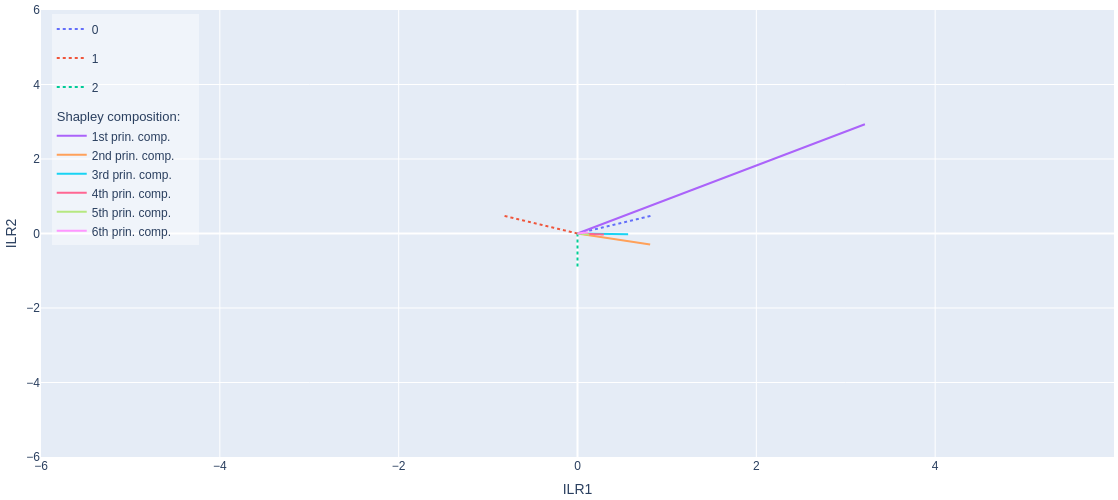

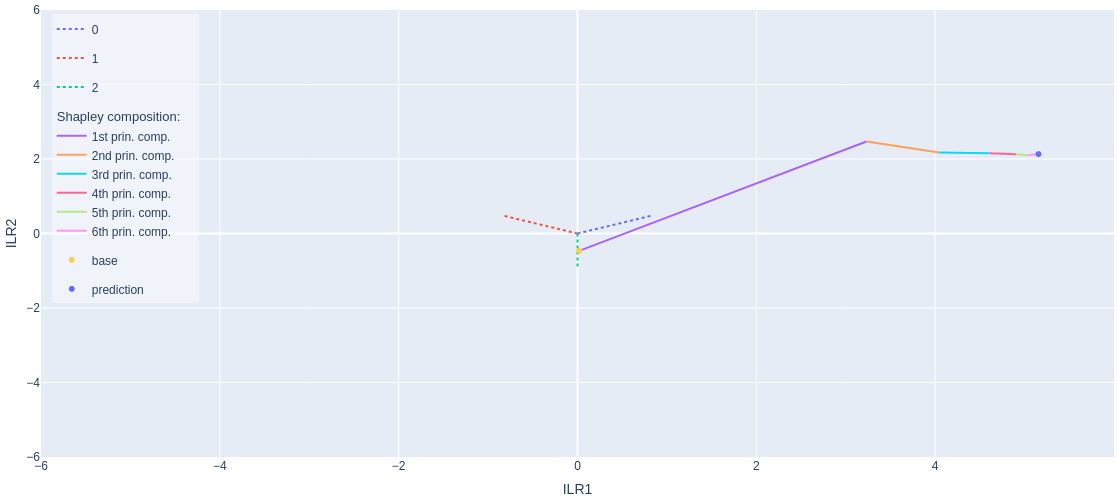

In [5]:
#PLOT the 3D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]

#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2, 3], lim=6, figsize=500)

fig = explainer.plot_ilr_space(balances=[1, 2, 3], shapley_sum=True, lim=6, figsize=500)


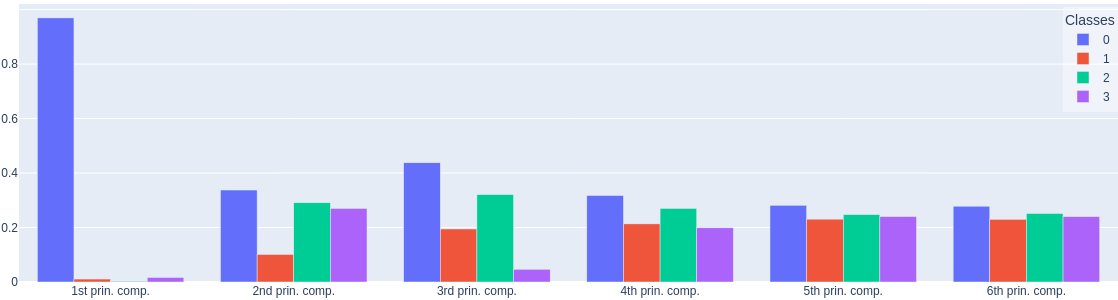

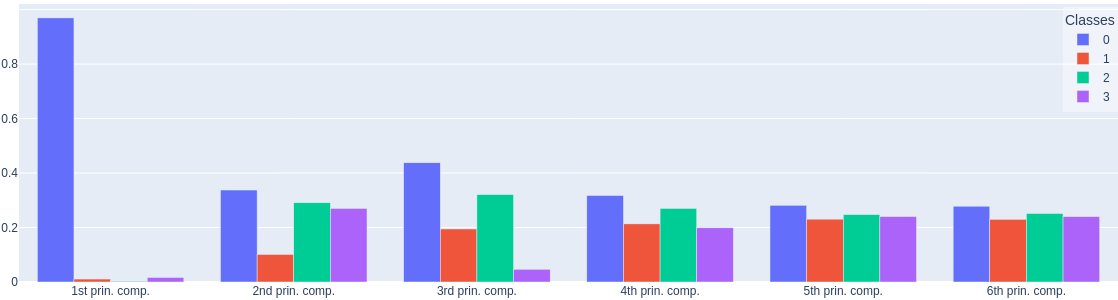

In [5]:
#Plot the Shapley compositions as histograms

explainer.shapley_histogram(figheight=300)